Import libraries

In [2]:
import requests
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import re
import numpy as np
import src.plotting as lol_plt
import pdb

Load a list of champions; I output it here so you can make it yourself. Note that Wukong is the 'monkeyking.'

In [8]:
champ_list = pd.read_csv('../champ list.csv', header=None)
champ_list.columns = ['Champion']
champ_list.Champion = champ_list.Champion.str.lower()
champ_list.Champion = champ_list.Champion.str.replace('[^\w]','')
print(champ_list.Champion.tolist(), )
champ_list.drop(49, inplace=True) # drop kindred

['ahri', 'akali', 'alistar', 'amumu', 'anivia', 'annie', 'ashe', 'azir', 'bard', 'blitzcrank', 'brand', 'braum', 'caitlyn', 'cassiopeia', 'chogath', 'corki', 'darius', 'diana', 'drmundo', 'draven', 'ekko', 'elise', 'evelynn', 'ezreal', 'fiddlesticks', 'fiora', 'fizz', 'galio', 'gangplank', 'garen', 'gnar', 'gragas', 'graves', 'hecarim', 'heimerdinger', 'irelia', 'janna', 'jarvaniv', 'jax', 'jayce', 'jinx', 'kalista', 'karma', 'karthus', 'kassadin', 'katarina', 'kayle', 'kennen', 'khazix', 'kindred', 'kogmaw', 'leblanc', 'leesin', 'leona', 'lissandra', 'lucian', 'lulu', 'lux', 'malphite', 'malzahar', 'maokai', 'masteryi', 'missfortune', 'mordekaiser', 'morgana', 'nami', 'nasus', 'nautilus', 'nidalee', 'nocturne', 'nunu', 'olaf', 'orianna', 'pantheon', 'poppy', 'quinn', 'rammus', 'reksai', 'renekton', 'rengar', 'riven', 'rumble', 'ryze', 'sejuani', 'shaco', 'shen', 'shyvana', 'singed', 'sion', 'sivir', 'skarner', 'sona', 'soraka', 'swain', 'syndra', 'tahmkench', 'talon', 'taric', 'teemo'

For each champion, create a URL for its webpage, then request it from League of Graphs

In [ ]:
champ_html = [requests.get('http://www.leagueofgraphs.com/champions/stats/'+ cur_champ) for cur_champ in list(champ_list['Champion'])]

## Load / save from pickle

To save time (and League of Graph's bandwidth), you can save the html to your computer.

In [17]:
with open('champ_html.pickle', 'wb') as champ_pickle:
    pickle.dump(champ_html, champ_pickle)

In [70]:
with open('champ_html.pickle', 'rb') as champ_pickle:
    champ_html = pickle.load(champ_pickle)

In [71]:
del champ_html[49] # delete kindred

## Calculate champion difficulty

First, we need to use regular expressions to extract the list with the win rates versus time from the html.

In [72]:
def get_wins_by_games(html):
    win_by_games_str = re.search('(?<=var d8 = ).*?]]', html).group(0)
    win_by_games_list = eval(win_by_games_str)
    return win_by_games_list

In [73]:
wins_by_games = np.array([get_wins_by_games(x.text) for x in champ_html])

Now we can plot the win rates versus time for some random champions.

In [86]:
def plot_wins_by_index( wins_by_index):
    for cur_game in wins_by_index:
        win_index, percent = zip(*cur_game)
        plt.plot(win_index, percent, 'grey')
    plt.ylabel('Win rate', fontsize = 18)
    lol_plt.prettify_axes(plt.gca())

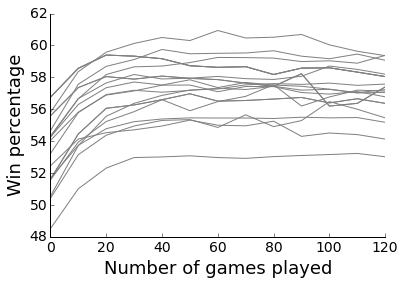

In [82]:
plot_wins_by_index( wins_by_games[np.random.randint(0, 125, 20)])
plt.xlabel('Number of games played', fontsize = 18)

Most champions increase their winrate as the number of games played increases. To calculate the learning change, we can subtract the maximum winrate from the minimum winrate. Then we can plot the histogram of changes in win rate

In [83]:
def get_learn_delta(game):
    _, percent = zip(*game)
    return max(percent) - min(percent)

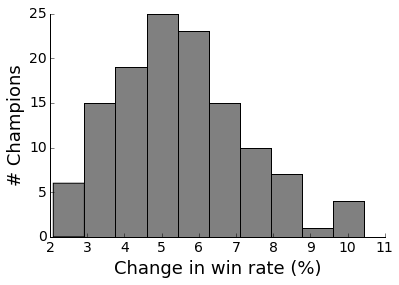

In [85]:
learn_deltas = [get_learn_delta(x) for x in wins_by_games]
learn_deltas = np.array(learn_deltas)
plt.hist(learn_deltas, bins=10, color = 'grey');
plt.xlabel('Change in win rate (%)', fontsize = 18)
plt.ylabel('# Champions', fontsize = 18)
lol_plt.prettify_axes(plt.gca())

Now we can investigate which champions have the highest learning curve. That is they have the biggest change in winrate.

In [54]:
high_skill_champs = np.where(learn_deltas > 8.5)
champ_list.iloc[high_skill_champs]

,Champion
7,azir
8,bard
41,kalista
77,reksai
79,rengar
82,ryze
99,thresh


This list looks pretty intuitive! Many highly mechanical champions like Azir and Rengar. Ryze is a surprisingly difficult champion apparently! Let's plot these champions win rate as a function of games played.

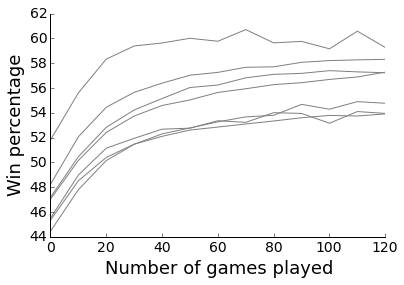

In [89]:
plot_wins_by_games(wins_by_games[high_skill_champs])
plt.xlabel('Number of games played', fontsize = 18);

Those are indeed steep learning curves.

Now we can turn to low skill champs, and repeat the same procedure.

In [90]:
low_skill_champs = np.where(learn_deltas < 3)
champ_list.iloc[low_skill_champs]

,Champion
27,galio
42,karma
46,kayle
58,malphite
63,mordekaiser
97,taric


This looks pretty good as well. What about their learning curves?

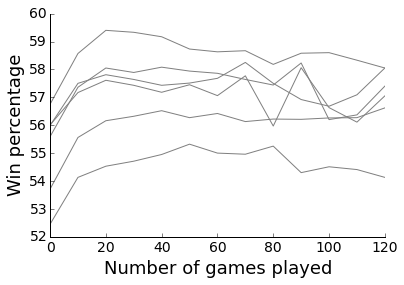

In [57]:
plot_wins_by_games(wins_by_games[low_skill_champs])

Most of these champions can be effectively mastered in twenty games. If you're looking to pick up ELO late in the season, you might try one of these. The high one here is Kayle.

# What are the late game champions?

We can perform a similar analysis to see which champions are late game carries, and which are best early in the game. First, we scrape the html for the win rates as a function of time..

In [58]:
def get_wins_by_time(html):
    wins_by_time_str = re.search('(?<=var d7 = ).*?]]', html).group(0)
    wins_by_time_list = eval(wins_by_time_str)
    return wins_by_time_list

In [59]:
wins_by_time =  np.array([get_wins_by_time(x.text) for x in champ_html])

Now we can plot the win rate as a function of time for some random champions.

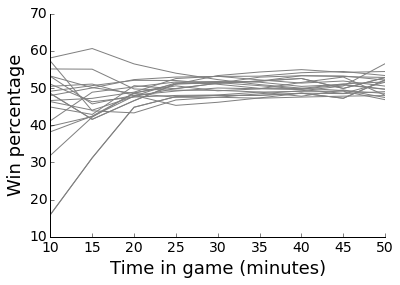

In [91]:
plot_wins_by_games( wins_by_time[np.random.randint(0, 125, 20)])
plt.xlabel('Time in game (minutes)', fontsize = 18)

This time, let's define the late game criterion as the change in win rate between 20 and 35 minutes (over 75% of games end by around 35-40 minutes).

In [92]:
def get_time_delta(game):
    _, percent = zip(*game)
    return percent[2] - percent[5] # win rate at 20 vs win rate at 35

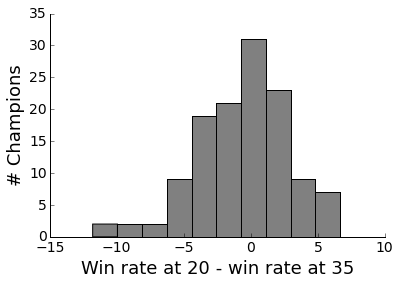

In [93]:
time_deltas = [get_time_delta(x) for x in wins_by_time]
time_deltas = np.array(time_deltas)
plt.hist(time_deltas, bins=10, color = 'grey');
plt.xlabel('Win rate at 20 - win rate at 35', fontsize = 18)
plt.ylabel('# Champions', fontsize = 18)
lol_plt.prettify_axes(plt.gca())

Now we can look at the early game champions.

In [64]:
early_champs = np.where(time_deltas >5)
champ_list.iloc[early_champs]

,Champion
4,anivia
9,blitzcrank
51,leblanc
52,leesin
73,pantheon


This list looks pretty good. Blitzcrank, Lee Sin, and Pantheon are all strong in the early game. The presence of Anivia is somewhat surprising here. Let's plot their win rate versus time.

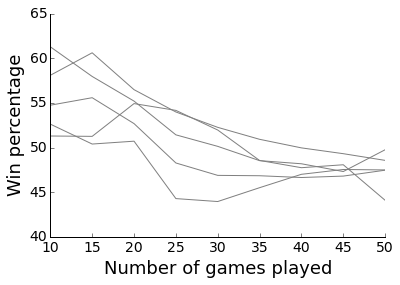

In [65]:
plot_wins_by_games( wins_by_time[early_champs])

Just what we wanted to see. Now we can turn to the late game champs.

In [68]:
late_champs = np.where(time_deltas < -6)
champ_list.iloc[late_champs]

,Champion
7,azir
13,cassiopeia
38,jax
74,poppy
115,warwick
120,yorick


This list also looks intuitive, with notorious hyper-scaling carries like Azir, Cassiopeia, Jax, and Poppy. I was kinda surprised by the presence of Warwick given his strong level 6 ganking, but I'm not a Warwick main, so what do I know. Let's plot their winrate.

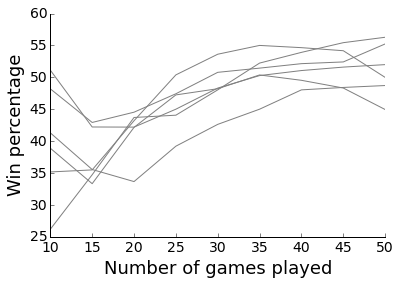

In [69]:
plot_wins_by_games( wins_by_time[late_champs])

All of these champions gain in win rate as the game goes on. They all have extremely mediocre early games to boot. You probably don't want to get too many of these on one team. That's all for this notebook!